In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_labels(padding_x, padding_y):

    all_features = pd.read_pickle(r'../data/all_features.pkl')
    all_features = all_features.sort_values(by='mesh_id').reset_index(drop=True)
    all_features = all_features[['mesh_id', 'latitude', 'longitude', 'area', 'prefecture']]
    all_features = all_features.drop_duplicates(subset=['mesh_id'], keep='first')

    reports_selected = pd.read_csv(r'../data/reports_selected.csv')
    lat_width = 75 / 9000
    lon_height = 0.0125
    
    all_features = all_features[all_features['prefecture'].isin(['tokyo'])]

    reports_selected = reports_selected[reports_selected['mesh_id'].isin(
        list(all_features['mesh_id'])
    )] # 31191 entries

    reports_selected = reports_selected.sort_values(by='mesh_id')
    labels_shape = (all_features.shape[0], 256, 256)

    labels = np.zeros(labels_shape)

    for label_idx, (_, group) in enumerate(reports_selected.groupby('mesh_id')):
        mesh_lat = all_features.iloc[label_idx]['latitude']
        mesh_lon = all_features.iloc[label_idx]['longitude']

        for _, row in group.iterrows():
            lat, lon = row['latitude'], row['longitude']

            lat_x = int((1 - ((lat - mesh_lat) / lat_width)) * labels_shape[1])
            lon_y = int(((lon - mesh_lon) / lon_height) * labels_shape[2])

            labels[label_idx, 
                max(lat_x - padding_x, 0): min(lat_x + padding_x + 1, labels_shape[1]), 
                max(lon_y - padding_y, 0): min(lon_y + padding_y + 1, labels_shape[2])] = 1

    return labels

In [3]:
def plot_label_sums(labels, label, color):

    nonempty_indexes = np.array([i for i in range(labels.shape[0]) if labels[i].sum() > 0.5])
    nonempty_labels = labels[nonempty_indexes]

    def generate_quadrants(images):
        height, width = images.shape[1], images.shape[2]
        half_height, half_width = height // 2, width // 2

        top_left = images[:, :half_height, :half_width]
        top_right = images[:, :half_height, half_width:]
        bottom_left = images[:, half_height:, :half_width]
        bottom_right = images[:, half_height:, half_width:]

        quadrants = np.stack([top_left, top_right, bottom_left, bottom_right], axis=1)
        return quadrants

    nonempty_label_quadrants = generate_quadrants(nonempty_labels)
    nonempty_label_quadrants = nonempty_label_quadrants.reshape(-1, 128, 128)
    # Apply removing empty features again
    # removes quadrants that are empty (but the original mesh isn't necessarily empty)

    nonempty_indexes2 = np.array([
        i for i in range(nonempty_label_quadrants.shape[0]) if nonempty_label_quadrants[i].sum() > 0.5])

    nonempty_label_quadrants = nonempty_label_quadrants[nonempty_indexes2]

    label_sums = nonempty_label_quadrants.sum(axis=(1, 2))
    label_sums /= (128 * 128)

    # sns.histplot(label_sums, kde=False, stat='density', bins=20, color='skyblue', edgecolor='black')
    sns.kdeplot(label_sums, fill=False, color=color, linestyle='-', linewidth=2, label=label)

In [12]:
def generate_label_sums(labels):

    nonempty_indexes = np.array([i for i in range(labels.shape[0]) if labels[i].sum() > 0.5])
    nonempty_labels = labels[nonempty_indexes]

    def generate_quadrants(images):
        height, width = images.shape[1], images.shape[2]
        half_height, half_width = height // 2, width // 2

        top_left = images[:, :half_height, :half_width]
        top_right = images[:, :half_height, half_width:]
        bottom_left = images[:, half_height:, :half_width]
        bottom_right = images[:, half_height:, half_width:]

        quadrants = np.stack([top_left, top_right, bottom_left, bottom_right], axis=1)
        return quadrants

    nonempty_label_quadrants = generate_quadrants(nonempty_labels)
    nonempty_label_quadrants = nonempty_label_quadrants.reshape(-1, 128, 128)
    # Apply removing empty features again
    # removes quadrants that are empty (but the original mesh isn't necessarily empty)

    nonempty_indexes2 = np.array([
        i for i in range(nonempty_label_quadrants.shape[0]) if nonempty_label_quadrants[i].sum() > 0.5])

    nonempty_label_quadrants = nonempty_label_quadrants[nonempty_indexes2]

    label_sums = nonempty_label_quadrants.sum(axis=(1, 2))
    label_sums /= (128 * 128)

    return label_sums

<Figure size 1500x1500 with 0 Axes>

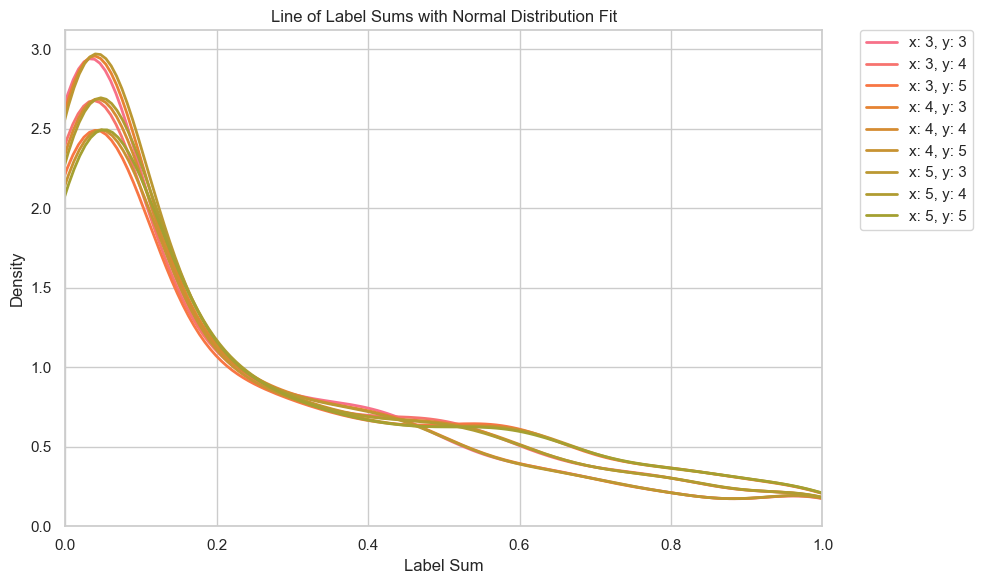

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 15))

limit = 6
colors = sns.color_palette("husl", limit**2)

plt.figure(figsize=(10, 6))

for idx, (padding_x, padding_y) in enumerate(
    [(x, y) for x in range(limit //  2, limit) for y in range(limit //  2, limit)]):
    
    labels = generate_labels(padding_x, padding_y)
    color = colors[idx]
    plot_label_sums(labels, label=f'x: {padding_x}, y: {padding_y}', color=color)

plt.title("Line of Label Sums with Normal Distribution Fit")
plt.xlabel("Label Sum")
plt.ylabel("Density")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

In [6]:
import plotly.io as pio
pio.renderers.default = "browser"

In [14]:
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

limit = 10
fig = go.Figure()

colors = [f"hsl({(i / (limit**2)) * 360}, 70%, 50%)" for i in range(limit**2)]

for idx, (padding_x, padding_y) in enumerate(
    [(x, y) for x in range(limit // 2, limit) for y in range(limit // 2, limit)]
):
    labels = generate_labels(padding_x, padding_y)
    label_sums = generate_label_sums(labels)

    kde = gaussian_kde(label_sums)
    x_vals = np.linspace(label_sums.min(), label_sums.max(), 200)
    y_vals = kde(x_vals)

    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            mode="lines",
            name=f"x: {padding_x}, y: {padding_y}",
            line=dict(color=colors[idx], width=2),
            hoverinfo="x+y+name",
        )
    )

fig.update_layout(
    title="Interactive KDE Plot of Label Sums",
    xaxis_title="Label Sum",
    yaxis_title="Density",
    legend=dict(title="Padding Combinations", x=1.05, y=1, orientation="v"),
    margin=dict(r=200),  # Adjust margin for legend
    template="plotly_white",
)

# Display the interactive plot
fig.show()